In [289]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, AdaBoostRegressor
from sklearn.svm import LinearSVR, SVR
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor

## Leitura e ajuste dos dados
Nessa parte foi realizada a Leitura dos dados, preparação de alguns dados tirando algumas colunas e eliminação de dados nulos

In [290]:
Transactions_csv = pd.read_csv('Transactions.csv')
before = Transactions_csv.shape[0]
print(Transactions_csv.shape)
Transactions_csv = Transactions_csv.dropna()
Transactions_csv = Transactions_csv.drop(['Date_and_time_of_unloading'], axis=1)
# Data_per_product = Transactions_csv[['Product_code', 'Profit']]
Data_per_product = Transactions_csv.groupby('Product_code')['Profit'].sum().reset_index()
Product_csv = pd.read_csv('Product_range.csv')
Info = pd.merge(Product_csv, Transactions_csv, on='Product_code')
# Info = Info.dropna()
Info.to_csv("Completa.csv")
after = Transactions_csv.shape[0]
print(Transactions_csv.shape[0])
print(1 - after/before)
# print(Info)

(50084, 8)
38297
0.23534462103665843


## Analise exploraória e Entendimento dos Dados

nessa parte vamos analisar o que estão acontecendo com os dados, possíveis desbalanceamentos, como estão distribuidos, dependências internas, e outras análises que podem ser relevantes para os negócios

In [291]:
import plotly.graph_objects as go
import plotly.express as px

df2 = pd.read_csv('Transactions.csv')
df2 = df2.dropna()


most_profitable = Info.sort_values('Profit', ascending=False)
Vendors_profit =  most_profitable[['Vendor_code', 'Profit']]
most_profitable = most_profitable[['Product_code','Profit', 'Name']]
Vendors_profit = Vendors_profit.dropna()
Vendors_profit = Vendors_profit.groupby('Vendor_code')['Profit'].sum().reset_index()
Vendors_profit = Vendors_profit.sort_values('Profit', ascending=False)


positive_profit = most_profitable.loc[most_profitable['Profit'] > 0]
positive_profit = positive_profit.groupby('Name')['Profit'].sum().reset_index()
positive_profit = positive_profit.sort_values('Profit', ascending=False)
print(positive_profit)

fig = px.histogram(positive_profit[:100], x="Name", y='Profit',barmode='relative',marginal='box', title='Distribution of the profit per product (top 100)', width=1200, height=600 ,template='plotly_dark', color='Name')
fig.update_layout(xaxis={'title': '', 'tickmode': 'array', 'tickvals': []})
fig.show()


fig = px.histogram(df2, x='Date_and_time_of_unloading', y='Profit',barmode='relative',marginal='box', title='Distribution of the profit relative to the date and time of unloading', width=1200, height=600 ,template='plotly_dark')
fig.show()



total_lucro = Vendors_profit['Profit'].sum()
Vendors_profit['Percentage'] = Vendors_profit['Profit'] / total_lucro * 100
Vendors_profit.loc[Vendors_profit['Percentage'] < 1, 'Vendor_code'] = 'Others'
Vendors_profit = Vendors_profit.groupby('Vendor_code').sum().reset_index()
Vendors_profit = Vendors_profit.sort_values('Percentage', ascending=False)
Top_Vendors_profit = Vendors_profit.drop(Vendors_profit.loc[Vendors_profit['Vendor_code'] == 'Others'].index)


fig = px.pie(Top_Vendors_profit, names='Vendor_code', values='Percentage', template='plotly_dark', title='Vendedores representatividade no lucro maior que 1%')
fig.update_traces(hovertemplate='<b>%{label}</b><br>%{percent}', textinfo='none')
fig.show()
print(Vendors_profit)
print("número total de vendedores relevantes:", Vendors_profit.shape[0])


                                                   Name     Profit
2976            Schneider Weisse TAP 7 Majn Orig Barrel  719622.01
3429           Verhaeghe Barbe Ruby / fruit beer / 7,7%  627515.02
1918                 Jaws Svit Stout Nitro Stout Barrel  500338.48
1660                             Gaffel Kolsch Barrel30  463602.36
3479                    Weihenstephaner Original Barrel  462827.33
...                                                 ...        ...
1045                            Chang Classic Lager 0,5      11.73
2540                          Organic Soba Noodles 300g      11.26
2541                          Organic Udon Noodles 300g      10.70
667   Bottle Share & Selfmade Nomisugi / session IPA...       9.30
3035      Siren Calypso / berliner weisse / 4% / 0,but.       3.39

[3800 rows x 2 columns]


         Vendor_code      Profit  Percentage
12            Others  6542252.36   25.173392
7               Jaws  3173897.83   12.212579
0            AF Brew  1702923.36    6.552538
21   Weihenstephaner  1439692.31    5.539673
24           Zagovor  1376002.69    5.294607
15           Saldens  1055319.21    4.060676
20         Verhaeghe  1049291.41    4.037482
16  Schneider Weisse   947809.51    3.646998
3            BrewDog   845102.55    3.251800
2        Big Village   742653.34    2.857594
1            Bakunin   711123.85    2.736275
23           XP Brew   617862.49    2.377422
9          Naparbier   586473.57    2.256643
13        Red Button   576434.81    2.218016
18        Stamm Beer   553755.38    2.130750
5           Hausmann   522527.92    2.010592
4             Gaffel   517925.30    1.992882
11         Ostrovica   504229.60    1.940183
6             Huyghe   461432.65    1.775509
8          Mikkeller   419914.52    1.615754
17           Sobolev   380637.08    1.464622
22        

Nessa análise vemos os produtos que mais dão lucro, melhores períodos do ano para vendas e distribuição dos vendedores

### Tabela de correlação
aqui percebe-se que há no modelo variáveis fortemente correlacionadas, isso influencia no nosso estudo e será o motivo de precisarmos retirar a variável Profit, como as vendas são muito influenciadas pela quantidade de lucro que se visa obter essa variável acaba prejudicando os modelos

<AxesSubplot: >

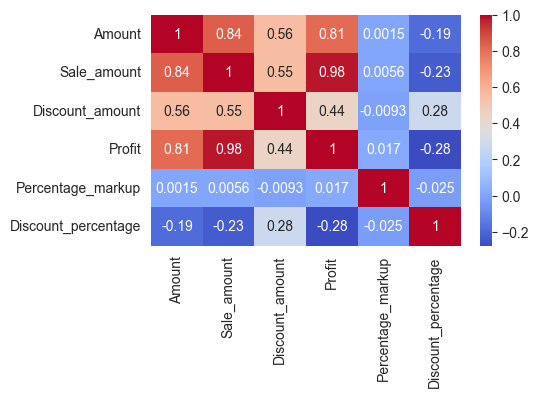

In [313]:
import seaborn as sns
Transactions_csv = pd.read_csv('Transactions.csv')
# Transactions_csv = pd.merge(Transactions_csv, Info[['Product_code', 'Retail_price']], on='Product_code', how='inner')
Transactions_csv = Transactions_csv.dropna()
Transactions_csv = Transactions_csv.drop(['Date_and_time_of_unloading', 'Product_code'], axis=1)
# print(Transactions_csv)
sns.set_style('darkgrid')
corr = Transactions_csv.corr()
fig, ax = plt.subplots(figsize=(5, 3))
sns.heatmap(corr, annot=True,cmap='coolwarm', ax=ax)

## Preparação dos dados de treino e teste
Nessa fase vamos determinar quais variáveis serão analizadas, nesse caso todas menos data, Profit e Sale_Amount que é o que estaremos prevendo, serão 80% dos dados pra treino e 20% pra teste, também vamos normalizar os dados para tentar melhorar o desempenho do modelo

In [293]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X = Transactions_csv.drop(['Sale_amount', 'Profit'], 1)
X = pd.DataFrame(scaler.fit_transform(X), columns= X.columns)
Transactions_csv['Sale_amount']= scaler.fit_transform(Transactions_csv[['Sale_amount']])
y = Transactions_csv['Sale_amount']
X_train, X_test, y_train, y_test =train_test_split(X,y, test_size= 0.20, random_state=42)

## Regressões Linear, Ridge, Lasso e Elastic
Aqui vamos ver como os modelos de regressão vão prever os dados e observar as métricas, aqui também percebemos que o alpha vai acabar não influenciando tanto nos modelos

In [294]:
#regressão com todos os atributos disponíveis
regr = LinearRegression()
y_pred = regr.fit(X_train, y_train).predict(X_test)

print("Mean squared error: %.f" % mean_squared_error(y_test, y_pred))
print("R Score: %.2f" % r2_score(y_test, y_pred))
print("Mean Absolute Error %.2f" % mean_absolute_error(y_test, y_pred))
print("Mean Absolute Percentage Error %.2f"% mean_absolute_percentage_error(y_test, y_pred))

Mean squared error: 0
R Score: 0.73
Mean Absolute Error 0.01
Mean Absolute Percentage Error 11.82


In [295]:
LinearRegression_results =[]
regr = LinearRegression()
y_pred = regr.fit(X_train, y_train).predict(X_test)

LinearRegression_results.append(mean_squared_error(y_test, y_pred))
LinearRegression_results.append(r2_score(y_test, y_pred))
LinearRegression_results.append(mean_absolute_error(y_test, y_pred))
LinearRegression_results.append(mean_absolute_percentage_error(y_test, y_pred))

In [296]:
import warnings
warnings.filterwarnings("ignore")

#regressão com todos os atributos disponíveis
regr = LinearRegression().fit(X_train, y_train)
y_pred = regr.predict(X_test)
print("Linear - error: %.2f" % mean_squared_error(y_test, y_pred))
print("R Score: %.2f" % r2_score(y_test, y_pred))
print("Mean Absolute Error %.2f"% mean_absolute_error(y_test, y_pred))
print("Mean Absolute Percentage Error %.2f"% mean_absolute_percentage_error(y_test, y_pred))
print("Parâmetros:", *regr.coef_)

#########

regRidge = Ridge(alpha=0).fit(X_train, y_train)
y_pred = regRidge.predict(X_test)
print("\nRidge alpha=0.0 - error: %.2f" % mean_squared_error(y_test, y_pred))
print("R Score: %.2f" % r2_score(y_test, y_pred))
print("Mean Absolute Error %.2f"% mean_absolute_error(y_test, y_pred))
print("Mean Absolute Percentage Error %.2f"% mean_absolute_percentage_error(y_test, y_pred))

regRidge = Ridge(alpha=0.5).fit(X_train, y_train)
y_pred = regRidge.predict(X_test)
print("Ridge alpha=0.5 - error: %.2f" % mean_squared_error(y_test, y_pred))
print("R Score: %.2f" % r2_score(y_test, y_pred))
print("Mean Absolute Error %.2f"% mean_absolute_error(y_test, y_pred))
print("Mean Absolute Percentage Error %.2f"% mean_absolute_percentage_error(y_test, y_pred))

regRidge = Ridge(alpha=1).fit(X_train, y_train)
y_pred = regRidge.predict(X_test)
print("Ridge alpha=1.0 - error: %.2f" % mean_squared_error(y_test, y_pred))
print("R Score: %.2f" % r2_score(y_test, y_pred))
print("Mean Absolute Error %.2f"% mean_absolute_error(y_test, y_pred))
print("Mean Absolute Percentage Error %.2f"% mean_absolute_percentage_error(y_test, y_pred))

regRidge = Ridge(alpha=2).fit(X_train, y_train)
y_pred = regRidge.predict(X_test)
print("Ridge alpha=2.0 - error: %.2f" % mean_squared_error(y_test, y_pred))
print("R Score: %.2f" % r2_score(y_test, y_pred))
print("Mean Absolute Error %.2f"% mean_absolute_error(y_test, y_pred))
print("Mean Absolute Percentage Error %.2f"% mean_absolute_percentage_error(y_test, y_pred))
print("Parâmetros:", *regRidge.coef_)

Linear - error: 0.00
R Score: 0.73
Mean Absolute Error 0.01
Mean Absolute Percentage Error 11.82
Parâmetros: 0.5839084378855469 0.4813395825725282 0.008221298725635408 -0.044146253831043425

Ridge alpha=0.0 - error: 0.00
R Score: 0.73
Mean Absolute Error 0.01
Mean Absolute Percentage Error 11.82
Ridge alpha=0.5 - error: 0.00
R Score: 0.73
Mean Absolute Error 0.01
Mean Absolute Percentage Error 11.53
Ridge alpha=1.0 - error: 0.00
R Score: 0.73
Mean Absolute Error 0.01
Mean Absolute Percentage Error 11.29
Ridge alpha=2.0 - error: 0.00
R Score: 0.73
Mean Absolute Error 0.01
Mean Absolute Percentage Error 10.90
Parâmetros: 0.5893453064224632 0.40128238330793903 0.00609762540912527 -0.041031144689893655


In [297]:
ridge_results = []
regRidge = Ridge(alpha=2).fit(X_train, y_train)
y_pred = regRidge.predict(X_test)
ridge_results.append(mean_squared_error(y_test, y_pred))
ridge_results.append(r2_score(y_test, y_pred))
ridge_results.append(mean_absolute_error(y_test, y_pred))
ridge_results.append(mean_absolute_percentage_error(y_test, y_pred))
print("Parâmetros:", regRidge.coef_)

Parâmetros: [ 0.58934531  0.40128238  0.00609763 -0.04103114]


In [298]:
regLasso = Lasso(alpha=0).fit(X_train, y_train)
y_pred = regLasso.predict(X_test)
print("\nLasso alpha=0.0 - error: %.2f" % mean_squared_error(y_test, y_pred))
print("R Score: %.2f" % r2_score(y_test, y_pred))
print("Mean Absolute Error %.2f"% mean_absolute_error(y_test, y_pred))
print("Mean Absolute Percentage Error %.2f"% mean_absolute_percentage_error(y_test, y_pred))

regLasso = Lasso(alpha=0.5).fit(X_train, y_train)
y_pred = regLasso.predict(X_test)
print("Lasso alpha=0.5 - error: %.2f" % mean_squared_error(y_test, y_pred))
print("R Score: %.2f" % r2_score(y_test, y_pred))
print("Mean Absolute Error %.2f"% mean_absolute_error(y_test, y_pred))
print("Mean Absolute Percentage Error %.2f"% mean_absolute_percentage_error(y_test, y_pred))

regLasso = Lasso(alpha=1).fit(X_train, y_train)
y_pred = regLasso.predict(X_test)
print("Lasso alpha=1.0 - error: %.2f" % mean_squared_error(y_test, y_pred))
print("R Score: %.2f" % r2_score(y_test, y_pred))
print("Mean Absolute Error %.2f"% mean_absolute_error(y_test, y_pred))
print("Mean Absolute Percentage Error %.2f"% mean_absolute_percentage_error(y_test, y_pred))

regLasso = Lasso(alpha=2).fit(X_train, y_train)
y_pred = regLasso.predict(X_test)
print("Lasso alpha=2.0 - error: %.2f" % mean_squared_error(y_test, y_pred))
print("R Score: %.2f" % r2_score(y_test, y_pred))
print("Mean Absolute Error %.2f"% mean_absolute_error(y_test, y_pred))
print("Mean Absolute Percentage Error %.2f"% mean_absolute_percentage_error(y_test, y_pred))
print("Parâmetros:", *regLasso.coef_)

regLasso = Lasso(alpha=4).fit(X_train, y_train)
y_pred = regLasso.predict(X_test)
print("Lasso alpha=4.0 - error: %.2f" % mean_squared_error(y_test, y_pred))
print("R Score: %.2f" % r2_score(y_test, y_pred))
print("Mean Absolute Error %.2f"% mean_absolute_error(y_test, y_pred))
print("Mean Absolute Percentage Error %.2f"% mean_absolute_percentage_error(y_test, y_pred))
print("Parâmetros:", *regLasso.coef_)



Lasso alpha=0.0 - error: 0.00
R Score: 0.73
Mean Absolute Error 0.01
Mean Absolute Percentage Error 11.82
Lasso alpha=0.5 - error: 0.00
R Score: -0.00
Mean Absolute Error 0.03
Mean Absolute Percentage Error 16.41
Lasso alpha=1.0 - error: 0.00
R Score: -0.00
Mean Absolute Error 0.03
Mean Absolute Percentage Error 16.41
Lasso alpha=2.0 - error: 0.00
R Score: -0.00
Mean Absolute Error 0.03
Mean Absolute Percentage Error 16.41
Parâmetros: 0.0 0.0 0.0 -0.0
Lasso alpha=4.0 - error: 0.00
R Score: -0.00
Mean Absolute Error 0.03
Mean Absolute Percentage Error 16.41
Parâmetros: 0.0 0.0 0.0 -0.0


In [299]:
lasso_results = []
regLasso = Lasso(alpha=4).fit(X_train, y_train)
y_pred = regLasso.predict(X_test)
lasso_results.append(mean_squared_error(y_test, y_pred))
lasso_results.append(r2_score(y_test, y_pred))
lasso_results.append(mean_absolute_error(y_test, y_pred))
lasso_results.append(mean_absolute_percentage_error(y_test, y_pred))

In [300]:
regElastic = ElasticNet(alpha=0).fit(X_train, y_train)
y_pred = regElastic.predict(X_test)
print("\nElastic alpha=0.0 - error: %.2f" % mean_squared_error(y_test, y_pred))
print("R Score: %.2f" % r2_score(y_test, y_pred))
print("Mean Absolute Error %.2f"% mean_absolute_error(y_test, y_pred))
print("Mean Absolute Percentage Error %.2f"% mean_absolute_percentage_error(y_test, y_pred))

regElastic = ElasticNet(alpha=1, l1_ratio=0).fit(X_train, y_train)
y_pred = regElastic.predict(X_test)
print("Elastic (Gamma=0 - Ridge) - error: %.2f" % mean_squared_error(y_test, y_pred))
print("R Score: %.2f" % r2_score(y_test, y_pred))
print("Mean Absolute Error %.2f"% mean_absolute_error(y_test, y_pred))
print("Mean Absolute Percentage Error %.2f"% mean_absolute_percentage_error(y_test, y_pred))

regElastic = ElasticNet(alpha=1, l1_ratio=0.5).fit(X_train, y_train)
y_pred = regElastic.predict(X_test)
print("Elastic (Gamma=0.5)       - error: %.2f" % mean_squared_error(y_test, y_pred))
print("R Score: %.2f" % r2_score(y_test, y_pred))
print("Mean Absolute Error %.2f"% mean_absolute_error(y_test, y_pred))
print("Mean Absolute Percentage Error %.2f"% mean_absolute_percentage_error(y_test, y_pred))

regElastic = ElasticNet(alpha=1, l1_ratio=1).fit(X_train, y_train)
y_pred = regElastic.predict(X_test)
print("Elastic (Gamma=1)       - error: %.2f" % mean_squared_error(y_test, y_pred))
print("R Score: %.2f" % r2_score(y_test, y_pred))
print("Mean Absolute Error %.2f"% mean_absolute_error(y_test, y_pred))
print("Mean Absolute Percentage Error %.2f"% mean_absolute_percentage_error(y_test, y_pred))


Elastic alpha=0.0 - error: 0.00
R Score: 0.73
Mean Absolute Error 0.01
Mean Absolute Percentage Error 11.82
Elastic (Gamma=0 - Ridge) - error: 0.00
R Score: 0.01
Mean Absolute Error 0.03
Mean Absolute Percentage Error 15.66
Elastic (Gamma=0.5)       - error: 0.00
R Score: -0.00
Mean Absolute Error 0.03
Mean Absolute Percentage Error 16.41
Elastic (Gamma=1)       - error: 0.00
R Score: -0.00
Mean Absolute Error 0.03
Mean Absolute Percentage Error 16.41


In [301]:
elastic_results = []
regElastic = ElasticNet(alpha=1, l1_ratio=1).fit(X_train, y_train)
y_pred = regElastic.predict(X_test)
elastic_results.append(mean_squared_error(y_test, y_pred))
elastic_results.append(r2_score(y_test, y_pred))
elastic_results.append(mean_absolute_error(y_test, y_pred))
elastic_results.append(mean_absolute_percentage_error(y_test, y_pred))

## LinearSVR
Esse modelo teve um dos piores desempenhos, percebemos que ele não é ideal para esse base de dados

In [302]:
y_pred = LinearSVR(epsilon = 0.5).fit(X_train,y_train).predict(X_test)
print("Mean squared error (epsilon=0.5): %.2f" % mean_squared_error(y_test, y_pred))
print("R Score (epsilon=0.5): %.2f" % r2_score(y_test, y_pred))
print("Mean Absolute Error %.2f"% mean_absolute_error(y_test, y_pred))
print("Mean Absolute Percentage Error %.2f"% mean_absolute_percentage_error(y_test, y_pred))

y_pred = LinearSVR(epsilon = 1.0).fit(X_train,y_train).predict(X_test)
print("\nMean squared error (epsilon=1.0): %.2f" % mean_squared_error(y_test, y_pred))
print("R Score (epsilon=1.0): %.2f" % r2_score(y_test, y_pred))
print("Mean Absolute Error %.2f"% mean_absolute_error(y_test, y_pred))
print("Mean Absolute Percentage Error %.2f"% mean_absolute_percentage_error(y_test, y_pred))

y_pred = LinearSVR(epsilon = 1.5).fit(X_train,y_train).predict(X_test)
print("\nMean squared error (epsilon=1.5): %.2f" % mean_squared_error(y_test, y_pred))
print("R Score (epsilon=1.5): %.2f" % r2_score(y_test, y_pred))
print("Mean Absolute Error %.2f"% mean_absolute_error(y_test, y_pred))
print("Mean Absolute Percentage Error %.2f"% mean_absolute_percentage_error(y_test, y_pred))

y_pred = LinearSVR(epsilon = 15).fit(X_train,y_train).predict(X_test)
print("\nMean squared error (epsilon=15): %.2f" % mean_squared_error(y_test, y_pred))
print("R Score (epsilon=15): %.2f" % r2_score(y_test, y_pred))
print("Mean Absolute Error %.2f"% mean_absolute_error(y_test, y_pred))
print("Mean Absolute Percentage Error %.2f"% mean_absolute_percentage_error(y_test, y_pred))

Mean squared error (epsilon=0.5): 0.06
R Score (epsilon=0.5): -28.90
Mean Absolute Error 0.25
Mean Absolute Percentage Error 168.99

Mean squared error (epsilon=1.0): 0.00
R Score (epsilon=1.0): -0.38
Mean Absolute Error 0.03
Mean Absolute Percentage Error 1.00

Mean squared error (epsilon=1.5): 0.00
R Score (epsilon=1.5): -0.38
Mean Absolute Error 0.03
Mean Absolute Percentage Error 1.00

Mean squared error (epsilon=15): 0.00
R Score (epsilon=15): -0.38
Mean Absolute Error 0.03
Mean Absolute Percentage Error 1.00


In [303]:
LinearSVR_results = []
y_pred = LinearSVR(epsilon = 0.5).fit(X_train,y_train).predict(X_test)
LinearSVR_results.append(mean_squared_error(y_test, y_pred))
LinearSVR_results.append(r2_score(y_test, y_pred))
LinearSVR_results.append(mean_absolute_error(y_test, y_pred))
LinearSVR_results.append(mean_absolute_percentage_error(y_test, y_pred))

## Decision Tree Regression
Um dos melhores modelos fora os ensembles, conseguiu métricas boas principalmente nas maiores profundidades

In [304]:
y_pred = DecisionTreeRegressor(max_depth=2).fit(X_train,y_train).predict(X_test)
print("Mean squared error (max_depth=2): %.2f" % mean_squared_error(y_test, y_pred))
print("R Score (max_depth=2): %.2f" % r2_score(y_test, y_pred))
print("Mean Absolute Error %.2f"% mean_absolute_error(y_test, y_pred))
print("Mean Absolute Percentage Error %.2f"% mean_absolute_percentage_error(y_test, y_pred))

y_pred = DecisionTreeRegressor(max_depth=5).fit(X_train,y_train).predict(X_test)
print("\nMean squared error (max_depth=5): %.2f" % mean_squared_error(y_test, y_pred))
print("R Score (max_depth=5): %.2f" % r2_score(y_test, y_pred))
print("Mean Absolute Error %.2f"% mean_absolute_error(y_test, y_pred))
print("Mean Absolute Percentage Error %.2f"% mean_absolute_percentage_error(y_test, y_pred))

y_pred = DecisionTreeRegressor(max_depth=10).fit(X_train,y_train).predict(X_test)
print("\nMean squared error (max_depth=10): %.2f" % mean_squared_error(y_test, y_pred))
print("R Score (max_depth=10): %.2f" % r2_score(y_test, y_pred))
print("Mean Absolute Error %.2f"% mean_absolute_error(y_test, y_pred))
print("Mean Absolute Percentage Error %.2f"% mean_absolute_percentage_error(y_test, y_pred))

y_pred = DecisionTreeRegressor().fit(X_train,y_train).predict(X_test)
print("\nMean squared error (max_depth= MAX): %.2f" % mean_squared_error(y_test, y_pred))
print("R Score (max_depth=MAX): %.2f" % r2_score(y_test, y_pred))
print("Mean Absolute Error %.2f"% mean_absolute_error(y_test, y_pred))
print("Mean Absolute Percentage Error %.2f" % mean_absolute_percentage_error(y_test, y_pred))

Mean squared error (max_depth=2): 0.00
R Score (max_depth=2): 0.63
Mean Absolute Error 0.01
Mean Absolute Percentage Error 7.22

Mean squared error (max_depth=5): 0.00
R Score (max_depth=5): 0.82
Mean Absolute Error 0.01
Mean Absolute Percentage Error 1.21

Mean squared error (max_depth=10): 0.00
R Score (max_depth=10): 0.96
Mean Absolute Error 0.00
Mean Absolute Percentage Error 0.24

Mean squared error (max_depth= MAX): 0.00
R Score (max_depth=MAX): 0.96
Mean Absolute Error 0.00
Mean Absolute Percentage Error 0.03


In [305]:
DecisionTree_results = []
y_pred = DecisionTreeRegressor().fit(X_train,y_train).predict(X_test)
DecisionTree_results.append(mean_squared_error(y_test, y_pred))
DecisionTree_results.append(r2_score(y_test, y_pred))
DecisionTree_results.append(mean_absolute_error(y_test, y_pred))
DecisionTree_results.append(mean_absolute_percentage_error(y_test, y_pred))

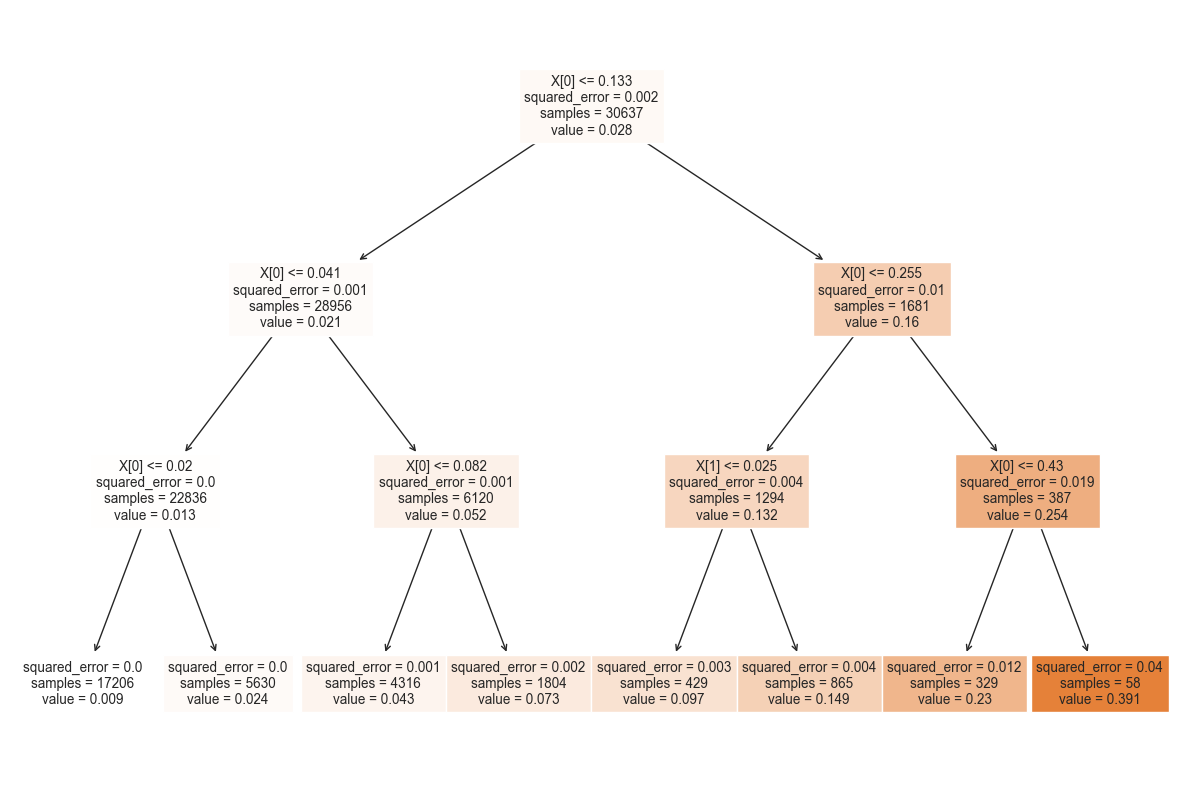

In [306]:
dct = DecisionTreeRegressor(max_depth=3).fit(X_train,y_train)

plt.figure(figsize=(15,10))
tree.plot_tree(dct, filled=True) 
plt.show(True)

## Ensembles
Além de demorado o Bagging não conseguiu ter um bom desempenho, o RandomForest foi o melhor modelo desse estudo teve um ótimo desempenho e ótimas métricas. Por fim o AdaBoost não conseguiu um desmpenho ótimo mas também não chegou ao R2 negstivo como o BaggingRegressor

In [307]:
BaggingRegressorBootstrap_results =[]
y_pred = BaggingRegressor(base_estimator=SVR(), n_estimators=10, n_jobs= -1).fit(X_train,y_train).predict(X_test)
print("Mean squared error - Bagging: %.2f" % mean_squared_error(y_test, y_pred))
print("R Score - Bagging: %.2f" % r2_score(y_test, y_pred))
print("Mean Absolute Error %.2f"% mean_absolute_error(y_test, y_pred))
print("Mean Absolute Percentage Error %.2f"% mean_absolute_percentage_error(y_test, y_pred))
BaggingRegressorBootstrap_results.append(mean_squared_error(y_test, y_pred))
BaggingRegressorBootstrap_results.append(r2_score(y_test, y_pred))
BaggingRegressorBootstrap_results.append(mean_absolute_error(y_test, y_pred))
BaggingRegressorBootstrap_results.append(mean_absolute_percentage_error(y_test, y_pred))

# Pasting é um Bagging sem reposição de exemplos (bootstrap=False)
BaggingRegressor_results = []
y_pred = BaggingRegressor(base_estimator=SVR(), n_estimators=10, bootstrap=False, n_jobs=-1).fit(X_train,y_train).predict(X_test)
print("\nMean squared error - Pasting: %.2f" % mean_squared_error(y_test, y_pred))
print("R Score - Pasting: %.2f" % r2_score(y_test, y_pred))
print("Mean Absolute Error %.2f"% mean_absolute_error(y_test, y_pred))
print("Mean Absolute Percentage Error %.2f"% mean_absolute_percentage_error(y_test, y_pred))
BaggingRegressor_results.append(mean_squared_error(y_test, y_pred))
BaggingRegressor_results.append(r2_score(y_test, y_pred))
BaggingRegressor_results.append(mean_absolute_error(y_test, y_pred))
BaggingRegressor_results.append(mean_absolute_percentage_error(y_test, y_pred))

RandomForest_results = []
y_pred = RandomForestRegressor(n_estimators=100, n_jobs=-1).fit(X_train,y_train).predict(X_test)
print("\nMean squared error - Random Forest: %.2f" % mean_squared_error(y_test, y_pred))
print("R Score - Random Forest: %.2f" % r2_score(y_test, y_pred))
print("Mean Absolute Error %.2f"% mean_absolute_error(y_test, y_pred))
print("Mean Absolute Percentage Error %.2f"% mean_absolute_percentage_error(y_test, y_pred))
RandomForest_results.append(mean_squared_error(y_test, y_pred))
RandomForest_results.append(r2_score(y_test, y_pred))
RandomForest_results.append(mean_absolute_error(y_test, y_pred))
RandomForest_results.append(mean_absolute_percentage_error(y_test, y_pred))

AdaBoost_results = []
y_pred = AdaBoostRegressor(n_estimators=50).fit(X_train,y_train).predict(X_test)
print("\nMean squared error - AdaBoost: %.2f" % mean_squared_error(y_test, y_pred))
print("R Score - AdaBoost: %.2f" % r2_score(y_test, y_pred))
print("Mean Absolute Error %.2f"% mean_absolute_error(y_test, y_pred))
print("Mean Absolute Percentage Error %.2f"% mean_absolute_percentage_error(y_test, y_pred))
AdaBoost_results.append(mean_squared_error(y_test, y_pred))
AdaBoost_results.append(r2_score(y_test, y_pred))
AdaBoost_results.append(mean_absolute_error(y_test, y_pred))
AdaBoost_results.append(mean_absolute_percentage_error(y_test, y_pred))

Mean squared error - Bagging: 0.01
R Score - Bagging: -2.09
Mean Absolute Error 0.08
Mean Absolute Percentage Error 58.48

Mean squared error - Pasting: 0.01
R Score - Pasting: -2.36
Mean Absolute Error 0.08
Mean Absolute Percentage Error 58.64

Mean squared error - Random Forest: 0.00
R Score - Random Forest: 0.98
Mean Absolute Error 0.00
Mean Absolute Percentage Error 0.03

Mean squared error - AdaBoost: 0.00
R Score - AdaBoost: 0.49
Mean Absolute Error 0.03
Mean Absolute Percentage Error 12.45


## Tabela de resultados

In [308]:
import pandas as pd
import plotly.graph_objects as go

metric_names = ['MSE', 'R2', 'MAE', 'MAPE']
model_names = ['LinearRegression', 'Ridge', 'Lasso', 'Elastic', 'LinearSVR', 'DecisionTree', 'BaggingRegressorBootstrap', 'BaggingRegressorNoBootStrap', 'RandomForestRegressor', 'AdaBoost']
data = [LinearRegression_results, ridge_results, lasso_results, elastic_results, LinearSVR_results, DecisionTree_results, BaggingRegressorBootstrap_results, BaggingRegressor_results, RandomForest_results, AdaBoost_results]
df = pd.DataFrame(data, columns=metric_names)
df.insert(0, 'Modelo', model_names)
print(df)

menores_valores = df.min()
cores_celulas = [['#e6e600' if col != 'Modelo' and ((col == 'R2' and val ==df[col].max()) or (col != 'R2' and val == min_val)) else '#d9d9d9' for val in df[col]] for col, min_val in menores_valores.items()]
cor_texto = '#000000'
fig = go.Figure(data=[go.Table(
    header=dict(values=list(df.columns),
                fill_color='#4d4d4d',
                align='left',
                font=dict(color='white')),
    cells=dict(values=[df[col] for col in df.columns],
               fill_color = cores_celulas,
               align='left',
               font=dict(color=cor_texto)))
])
# fig.update_layout(template='plotly_dark')

fig.show()


                        Modelo       MSE         R2       MAE        MAPE
0             LinearRegression  0.000581   0.727489  0.012194   11.817728
1                        Ridge  0.000582   0.727209  0.012355   10.902323
2                        Lasso  0.002133  -0.000008  0.026309   16.409563
3                      Elastic  0.002133  -0.000008  0.026309   16.409563
4                    LinearSVR  0.063758 -28.895644  0.250329  168.988148
5                 DecisionTree  0.000109   0.948877  0.001876    0.032827
6    BaggingRegressorBootstrap  0.006601  -2.094943  0.078491   58.481521
7  BaggingRegressorNoBootStrap  0.007157  -2.355698  0.082432   58.639469
8        RandomForestRegressor  0.000038   0.982285  0.001085    0.034654
9                     AdaBoost  0.001091   0.488579  0.028773   12.448552


## Relevância das variáveis
Aqui entendemos como o modelo está usando as variáveis e quão relevante elas estão sendo para a previsão

                            0
Amount               0.717465
Discount_amount      0.129878
Percentage_markup    0.017563
Discount_percentage  0.135093


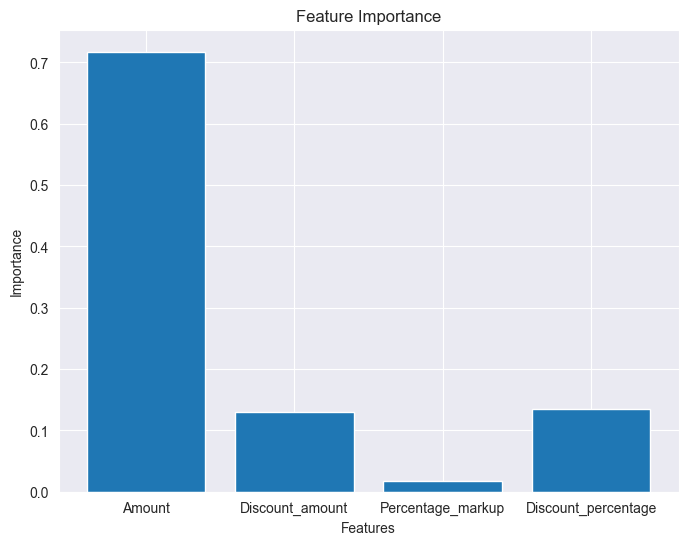


Mean squared error - RandomForestRegrssor: 0.00
R Score - RandomForestRegrssor: 0.48857873
Mean Absolute Error 0.02877277
Mean Absolute Percentage Error 12.44855237


In [309]:
model = RandomForestRegressor(n_estimators=100, n_jobs=-1)
model.fit(X, y)
# Calcular a importância das features
importances = model.feature_importances_
importancesdf = pd.DataFrame(importances, X.columns)
print(importancesdf)
# Criar gráfico de barras das importâncias
plt.figure(figsize=(8, 6))
plt.bar(X.columns, importances)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.show()
print("\nMean squared error - RandomForestRegrssor: %.2f" % mean_squared_error(y_test, y_pred))
print("R Score - RandomForestRegrssor: %.8f" % r2_score(y_test, y_pred))
print("Mean Absolute Error %.8f"% mean_absolute_error(y_test, y_pred))
print("Mean Absolute Percentage Error %.8f"% mean_absolute_percentage_error(y_test, y_pred))

## Stacking Regressor

In [311]:
#stacking

from sklearn.ensemble import StackingRegressor

model1 = Ridge()
model2 = DecisionTreeRegressor()
model3 = LinearRegression()

meta_model = RandomForestRegressor(n_estimators=100)
stacked_model = StackingRegressor(
    estimators=[('Ridge', model1), ('DecisionTree', model2), ('LinearRegression', model3)],
    final_estimator=meta_model
)

stacked_model.fit(X_train, y_train)
y_pred = stacked_model.predict(X_test)

Stacking_results = []
print("\nMean squared error - StackingRegressor: %.2f" % mean_squared_error(y_test, y_pred))
print("R Score - StackingRegressor: %.8f" % r2_score(y_test, y_pred))
print("Mean Absolute Error %.8f"% mean_absolute_error(y_test, y_pred))
print("Mean Absolute Percentage Error %.8f"% mean_absolute_percentage_error(y_test, y_pred))
Stacking_results.append(mean_squared_error(y_test, y_pred))
Stacking_results.append(r2_score(y_test, y_pred))
Stacking_results.append(mean_absolute_error(y_test, y_pred))
Stacking_results.append(mean_absolute_percentage_error(y_test, y_pred))



Mean squared error - StackingRegressor: 0.00
R Score - StackingRegressor: 0.95277812
Mean Absolute Error 0.00206606
Mean Absolute Percentage Error 0.04352938


## Tabela final de resultados

In [312]:
metric_names = ['MSE', 'R2', 'MAE', 'MAPE']
model_names = ['LinearRegression', 'Ridge', 'Lasso', 'Elastic', 'LinearSVR', 'DecisionTree', 'BaggingRegressorBootstrap', 'BaggingRegressorNoBootStrap', 'RandomForestRegressor', 'AdaBoost', 'StackingRegressor']
data = [LinearRegression_results, ridge_results, lasso_results, elastic_results, LinearSVR_results, DecisionTree_results, BaggingRegressorBootstrap_results, BaggingRegressor_results, RandomForest_results, AdaBoost_results, Stacking_results]
df = pd.DataFrame(data, columns=metric_names)
df.insert(0, 'Modelo', model_names)
print(df)

menores_valores = df.min()
cores_celulas = [['#e6e600' if col != 'Modelo' and ((col == 'R2' and val ==df[col].max()) or (col != 'R2' and val == min_val)) else '#d9d9d9' for val in df[col]] for col, min_val in menores_valores.items()]
cor_texto = '#000000'
fig = go.Figure(data=[go.Table(
    header=dict(values=list(df.columns),
                fill_color='#4d4d4d',
                align='left',
                font=dict(color='white')),
    cells=dict(values=[df[col] for col in df.columns],
               fill_color = cores_celulas,
               align='left',
               font=dict(color=cor_texto)))
])
# fig.update_layout(template='plotly_dark')

fig.show()

                         Modelo       MSE         R2       MAE        MAPE
0              LinearRegression  0.000581   0.727489  0.012194   11.817728
1                         Ridge  0.000582   0.727209  0.012355   10.902323
2                         Lasso  0.002133  -0.000008  0.026309   16.409563
3                       Elastic  0.002133  -0.000008  0.026309   16.409563
4                     LinearSVR  0.063758 -28.895644  0.250329  168.988148
5                  DecisionTree  0.000109   0.948877  0.001876    0.032827
6     BaggingRegressorBootstrap  0.006601  -2.094943  0.078491   58.481521
7   BaggingRegressorNoBootStrap  0.007157  -2.355698  0.082432   58.639469
8         RandomForestRegressor  0.000038   0.982285  0.001085    0.034654
9                      AdaBoost  0.001091   0.488579  0.028773   12.448552
10            StackingRegressor  0.000101   0.952778  0.002066    0.043529


## Conclusão

O random Forest foi o melhor modelo superando os demais ensembles com ótimas métricas principalmente em MSE e R2, vale lembrar que estamos com poucas variáveis e elas também são muito relacionadas o que influencia diretamente nas métricas do modelo.